In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd

%matplotlib inline

/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


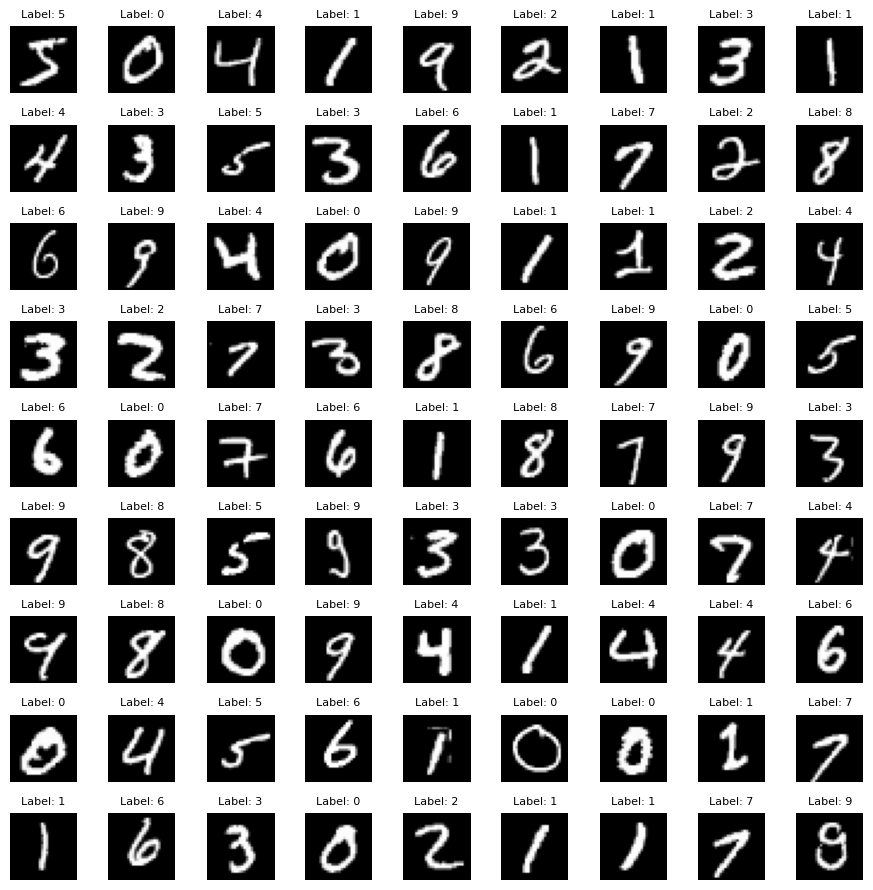

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing image shapes
print("Train images shape:", x_train.shape) 
print("Train labels shape:", y_train.shape)  
print("Test images shape:", x_test.shape)    
print("Test labels shape:", y_test.shape)   

# Display a 9x9 grid of training images
plt.figure(figsize=(9, 9))
for i in range(81):  # 9x9 = 81 images
    plt.subplot(9, 9, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}', fontsize=8)
    plt.axis('off')  # Hide axes for cleaner display
plt.tight_layout()
plt.show()

In [3]:

# Converting to Pytorch Tensor format and normalising
train_X = torch.from_numpy(x_train).float().unsqueeze(1) / 255.0  # Add channel dim
test_X = torch.from_numpy(x_test).float().unsqueeze(1) / 255.0    # [N, 1, 28, 28]

# Converting Labels to Pytorch Labels
train_y = torch.from_numpy(y_train).long()
test_y = torch.from_numpy(y_test).long()

In [4]:
# Creating DataLoaders
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

batch_X, batch_y = next(iter(train_loader))
print("Batch images shape:", batch_X.shape)  # torch.Size([64, 1, 28, 28])
print("Batch labels shape:", batch_y.shape)  # torch.Size([64])

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [5]:
# Defining the CNN model 

class CNN(nn.Module):

    # Constructor will process the input
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = 1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 64x14x14
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)       # Output: 64x7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                    # Flatten: 64*7*7 -> 128
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)                            # Output: 10 classes
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu3(self.fc1(x))       
        x = self.fc2(x)
        return x

In [6]:
# Updated training function to track time and convergence
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device, patience=3, threshold=0.001):
    train_losses = []
    val_losses = []
    epoch_times = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    converged_epoch = epochs  # Default to max epochs if no convergence
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        epoch_val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Track epoch time
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        
        # Check for convergence
        if best_val_loss - epoch_val_loss > threshold:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                converged_epoch = epoch + 1
                print(f'Early stopping at epoch {converged_epoch} for convergence.')
                break
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {epoch_time:.3f}s')
    
    return train_losses, val_losses, epoch_times, converged_epoch

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Model parameters (from your code)
epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

In [ ]:
# Dictionary to store results for each optimizer
results = {
    'Optimizer': [],
    'Converged Epoch': [],
    'Avg Time per Epoch (s)': [],
    'Total Time (s)': [],
    'Final Train Loss': []
}

# List of optimizers to compare
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

# Train and evaluate for each optimizer
all_train_losses = {}
all_val_losses = {}
for opt_name, opt_class in optimizers.items():
    print(f"\nTraining with {opt_name}...")
    model = CNN().to(device)
    optimizer = opt_class(model.parameters(), lr=learning_rate)
    train_losses, val_losses, epoch_times, converged_epoch = train_model(
        model, train_loader, test_loader, optimizer, criterion, epochs, device
    )
    all_train_losses[opt_name] = train_losses
    all_val_losses[opt_name] = val_losses
    
    # Store results
    results['Optimizer'].append(opt_name)
    results['Converged Epoch'].append(converged_epoch)
    results['Avg Time per Epoch (s)'].append(sum(epoch_times) / len(epoch_times))
    results['Total Time (s)'].append(sum(epoch_times))
    results['Final Train Loss'].append(train_losses[-1])

# Create and display the results table
results_df = pd.DataFrame(results)
print("\nResults Table:")
print(results_df)


Training with SGD...
Epoch 1/10, Train Loss: 2.2726, Val Loss: 2.2354, Time: 16.756s


In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
for opt_name in optimizers.keys():
    plt.plot(range(1, len(all_train_losses[opt_name])+1), all_train_losses[opt_name], label=f'{opt_name} Train Loss')
    plt.plot(range(1, len(all_val_losses[opt_name])+1), all_val_losses[opt_name], '--', label=f'{opt_name} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()